In [1]:
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd
import os
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)



In [3]:
# Create val dataset
val_size = 0.2
np.random.seed(42)
idxs = np.random.permutation(len(train_dataset))
val_idxs, train_idxs = idxs[: int(len(train_dataset) * val_size)], idxs[int(len(train_dataset) * val_size):]
val_sampler = SubsetRandomSampler(val_idxs)
train_sampler = SubsetRandomSampler(train_idxs)

In [4]:
print(len(train_dataset))
print(len(train_dataset[0]))
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

60000
2
torch.Size([1, 28, 28])
5


In [5]:
labels = np.array([x[1] for x in test_dataset])
print(np.unique(labels))

[0 1 2 3 4 5 6 7 8 9]


In [6]:
from functools import reduce

model_setting = {
    'input_size': reduce(lambda a, b: a*b, train_dataset[0][0].shape),  # 784
    'hidden_size_1': 500,
    'hidden_size_2': 400,
    'hidden_size_3': 30,
    'num_classes': len(np.unique(labels)),
}

num_epochs = 30
batch_size = 500
learning_rate_adam = 0.001
learning_rate_SGD = 0.01
val_size = 0.2

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    sampler=train_sampler)
val_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    sampler=val_sampler)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size)

In [8]:
# Accuracy metrics
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes, early_stop_count=3):
        super(NeuralNet, self).__init__()
        # Input
        self.input_size = input_size
        self.input_layer = nn.Linear(input_size, hidden_size_1) 
        # Activation
        self.relu = nn.ReLU()
        # Hidden Layers
        self.l1 = nn.Linear(hidden_size_1, hidden_size_2)
        self.l2 = nn.Linear(hidden_size_2, hidden_size_3)
        # Output
        self.output = nn.Linear(hidden_size_3, num_classes)
        
        # Early stop
        self.eval_loss = None
        self.early_stop_count = early_stop_count
        self.stop_counter = 0
    
    def forward(self, input):
        out = self.input_layer(input)
        out = self.relu(out)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)

        return self.output(out)
    
    def fit(self, loader, num_epochs, criterion, optimizer, scheduler, val_loader):
        # Train the model
        losses, val_losses = [], []
        train_acc, val_acc = [], []

        for epoch in range(1, num_epochs + 1):
            e_loss, e_val_loss = [], []
            e_train_acc, e_val_acc = [], []

            for images, labels in loader:
                self.train()

                # Forward pass
                loss, outputs = self.forward_pass(images, labels, criterion)
                
                # Backward and optimize
                self.optimizer_step(optimizer, loss)
                
                # Metrics
                e_loss.append(loss.item())
                e_train_acc.append(accuracy(outputs, labels))
            
            scheduler.step()
            
            for images, labels in val_loader:
                self.eval()
                
                loss, outputs = self.forward_pass(images, labels, criterion)
                
                # Metrics
                e_val_loss.append(loss.item())
                e_val_acc.append(accuracy(outputs, labels))
            
            v_loss = sum(e_val_loss) / len(e_val_loss)

            self.update_eval(v_loss)

            losses.append(sum(e_loss) / len(e_loss))
            val_losses.append(v_loss)
            
            train_acc.append(sum(e_train_acc) / len(e_train_acc))
            val_acc.append(sum(e_val_acc) / len(e_val_acc))
            
            if model.early_stop:
                print(f'No increase in validation loss since epoch {epoch - model.early_stop_count}\nStopping Traing')
                break

            print (f'Epoch [{epoch}/{num_epochs}], train_loss: {losses[-1]:.4f}, val_loss {val_losses[-1]:.4f}, val_acc {val_acc[-1]:.2f}')

        return pd.DataFrame(list(zip(losses, val_losses, train_acc, val_acc)), columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    

    @staticmethod
    def optimizer_step(optimizer, loss):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def forward_pass(self, x, y, criterion):
        features = x.reshape(-1, 28*28).to(device)
        y = y.to(device)
        outputs = self(features)
        loss = criterion(outputs, y)

        return loss, outputs

    def update_eval(self, eval_loss):
        if not self.eval_loss:
            self.eval_loss = eval_loss
        elif eval_loss < self.eval_loss:
            self.stop_counter = 0
            self.eval_loss = eval_loss
            torch.save(self.state_dict(), os.path.join('./data/torch_models/', 'best.pth'))
        else:
            self.stop_counter += 1
    
    @property
    def early_stop(self):
        return self.stop_counter >= self.early_stop_count

In [10]:
from torch.optim.lr_scheduler import ExponentialLR

model = NeuralNet(**model_setting).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)  
scheduler = ExponentialLR(optimizer, gamma=0.9)

history = model.fit(train_loader, num_epochs, criterion, optimizer, scheduler, val_loader=val_loader)

Epoch [1/30], train_loss: 0.6533, val_loss 0.2614, val_acc 0.92
Epoch [2/30], train_loss: 0.2202, val_loss 0.1871, val_acc 0.95
Epoch [3/30], train_loss: 0.1562, val_loss 0.1608, val_acc 0.95
Epoch [4/30], train_loss: 0.1253, val_loss 0.1295, val_acc 0.96
Epoch [5/30], train_loss: 0.1004, val_loss 0.1087, val_acc 0.97
Epoch [6/30], train_loss: 0.0838, val_loss 0.1010, val_acc 0.97
Epoch [7/30], train_loss: 0.0699, val_loss 0.0940, val_acc 0.97
Epoch [8/30], train_loss: 0.0595, val_loss 0.0923, val_acc 0.97
Epoch [9/30], train_loss: 0.0523, val_loss 0.0900, val_acc 0.97
Epoch [10/30], train_loss: 0.0459, val_loss 0.0831, val_acc 0.98
Epoch [11/30], train_loss: 0.0391, val_loss 0.0814, val_acc 0.98
Epoch [12/30], train_loss: 0.0341, val_loss 0.0812, val_acc 0.98
Epoch [13/30], train_loss: 0.0307, val_loss 0.0822, val_acc 0.98
Epoch [14/30], train_loss: 0.0276, val_loss 0.0812, val_acc 0.98
Epoch [15/30], train_loss: 0.0244, val_loss 0.0791, val_acc 0.98
Epoch [16/30], train_loss: 0.0219,

Text(0.5, 1.0, 'Accuracy')

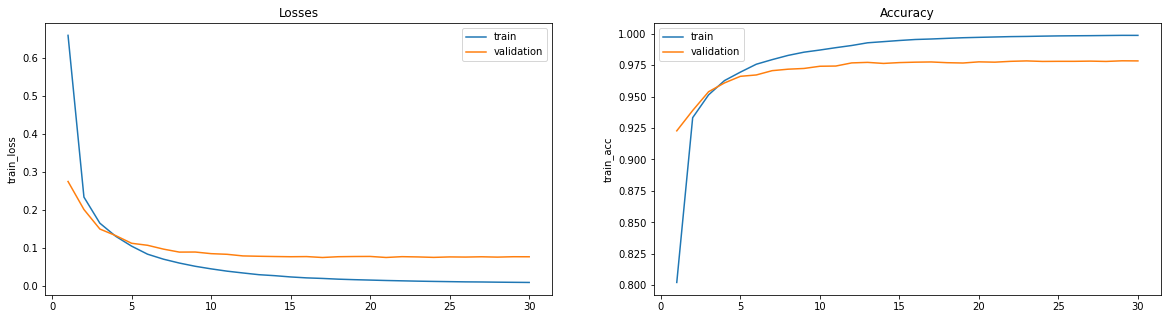

In [11]:
_, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.lineplot(x=range(1, len(history) + 1), y='train_loss', ax=axs[0], label='train', data=history)
sns.lineplot(x=range(1, len(history) + 1), y='val_loss', ax=axs[0], label='validation', data=history)
axs[0].set_title('Losses')
sns.lineplot(x=range(1, len(history) + 1), y='train_acc', ax=axs[1], label='train', data=history)
sns.lineplot(x=range(1, len(history) + 1), y='val_acc', ax=axs[1], label='validation', data=history)
axs[1].set_title('Accuracy')


In [12]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    
    model = NeuralNet(**model_setting).to(device)
    model.load_state_dict(torch.load('data/torch_models/best.pth'))

    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.72 %


Compare train / eval-loss for two different optimizers. Adam & SGD
include learning rate scheduler

In [13]:
model = NeuralNet(**model_setting).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_SGD, momentum=0.9)  
scheduler = ExponentialLR(optimizer, gamma=0.9)

history_SGD = model.fit(train_loader, num_epochs, criterion, optimizer, scheduler, val_loader)

Epoch [1/30], train_loss: 2.2444, val_loss 2.0627, val_acc 0.39
Epoch [2/30], train_loss: 1.3841, val_loss 0.7486, val_acc 0.77
Epoch [3/30], train_loss: 0.5863, val_loss 0.4745, val_acc 0.86
Epoch [4/30], train_loss: 0.4381, val_loss 0.3934, val_acc 0.89
Epoch [5/30], train_loss: 0.3762, val_loss 0.3508, val_acc 0.90
Epoch [6/30], train_loss: 0.3365, val_loss 0.3174, val_acc 0.91
Epoch [7/30], train_loss: 0.3091, val_loss 0.2971, val_acc 0.91
Epoch [8/30], train_loss: 0.2871, val_loss 0.2799, val_acc 0.92
Epoch [9/30], train_loss: 0.2706, val_loss 0.2663, val_acc 0.92
Epoch [10/30], train_loss: 0.2558, val_loss 0.2526, val_acc 0.93
Epoch [11/30], train_loss: 0.2437, val_loss 0.2444, val_acc 0.93
Epoch [12/30], train_loss: 0.2340, val_loss 0.2368, val_acc 0.93
Epoch [13/30], train_loss: 0.2247, val_loss 0.2280, val_acc 0.94
Epoch [14/30], train_loss: 0.2176, val_loss 0.2216, val_acc 0.94
Epoch [15/30], train_loss: 0.2108, val_loss 0.2176, val_acc 0.94
Epoch [16/30], train_loss: 0.2054,

Text(0.5, 1.0, 'Validation')

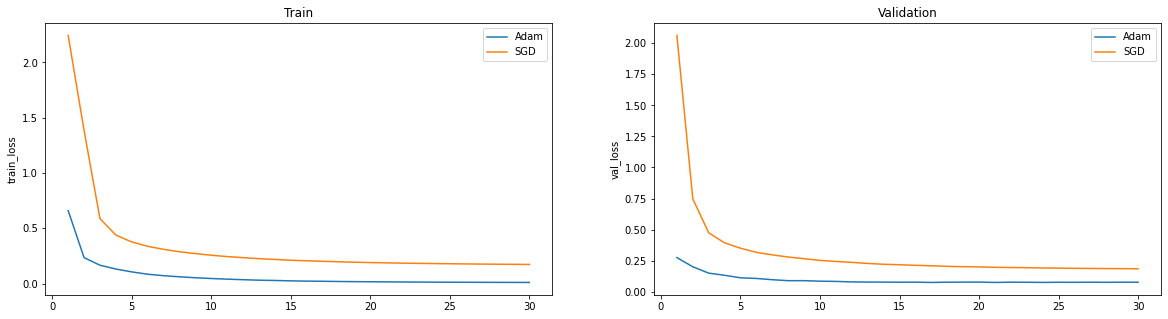

In [15]:
_, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.lineplot(x=range(1, len(history) + 1), y='train_loss', ax=axs[0], label='Adam', data=history)
sns.lineplot(x=range(1, len(history_SGD) + 1), y='train_loss', ax=axs[0], label='SGD', data=history_SGD)
axs[0].set_title('Train')

sns.lineplot(x=range(1, len(history) + 1), y='val_loss', ax=axs[1], label='Adam', data=history)
sns.lineplot(x=range(1, len(history) + 1), y='val_loss', ax=axs[1], label='SGD', data=history_SGD)
axs[1].set_title('Validation')

<AxesSubplot:>

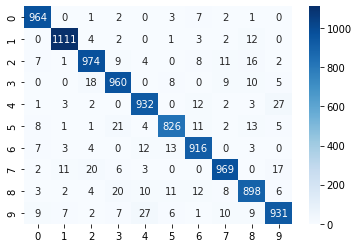

In [36]:
from sklearn.metrics import confusion_matrix

pred = []
y_true = []
with torch.no_grad():
    
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        for p, y in zip(predicted, labels):
            pred.append(p.item())
            y_true.append(y.item())

sns.heatmap(confusion_matrix(y_true, pred), annot=True, cmap='Blues', fmt=".0f")

Training model with batch size 2
Epoch [1/1], train_loss: 2.3099, val_loss 2.3099, val_acc 0.10
Training model with batch size 4
Epoch [1/1], train_loss: 2.3086, val_loss 2.3080, val_acc 0.09
Training model with batch size 8
Epoch [1/1], train_loss: 2.3134, val_loss 2.3132, val_acc 0.09
Training model with batch size 16
Epoch [1/1], train_loss: 2.3047, val_loss 2.3058, val_acc 0.11
Training model with batch size 32
Epoch [1/1], train_loss: 2.3077, val_loss 2.3083, val_acc 0.10


<AxesSubplot:>

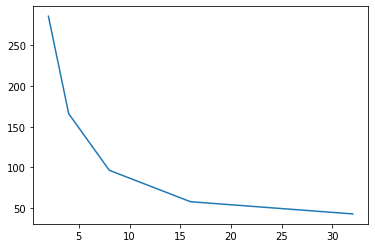

In [51]:
import time

batch_sizes = [2, 4, 8, 16, 32]  

loaders = [[DataLoader(dataset=train_dataset, batch_size=b_s, sampler=train_sampler), DataLoader(dataset=train_dataset, batch_size=b_s, sampler=val_sampler)] for b_s in batch_sizes]

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)  
scheduler = ExponentialLR(optimizer, gamma=0.9)

elapsed_time = []
for i, (train_loader, val_loader) in enumerate(loaders):

    model = NeuralNet(**model_setting).to(device)
    start = time.time()
    print(f'Training model with batch size {batch_sizes[i]}')
    model.fit(train_loader, 1, criterion, optimizer, scheduler, val_loader)
    end = time.time()
    elapsed_time.append(end-start)

sns.lineplot(x=batch_sizes, y=elapsed_time)
